In [1]:
# Load required packages
import numpy as np
import scanpy as sc
import seaborn as sns
import celltypist
from celltypist import models
from scipy.stats import median_abs_deviation
from matplotlib import pyplot as plt
from scipy.sparse import issparse
from scipy.sparse import csr_matrix, issparse


sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=150,
    dpi_save=700,
    facecolor="white",
    vector_friendly=False,
    frameon=False,
)

import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
library(SoupX)
library(scran)
library(BiocParallel)
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)
library(scry)

In [14]:
# Load the filtered matrix of the E13.5 heart scRNA-seq data
adata = sc.read_10x_h5(
    filename="/mnt/sdb/qdang/singlecell/epi/E135/outs/filtered_feature_bc_matrix.h5",
)
adata

AnnData object with n_obs × n_vars = 11363 × 31054
    var: 'gene_ids', 'feature_types', 'genome'

In [16]:
# Define gene groups of interest for QC
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("rps", "rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^hb[^(p)]"))

In [17]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 11363 × 31054
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


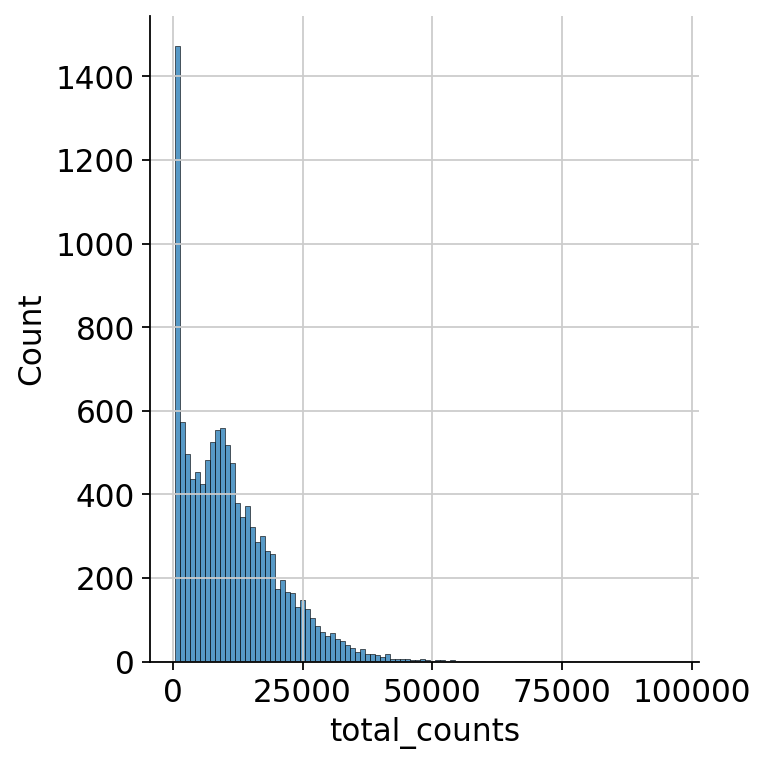

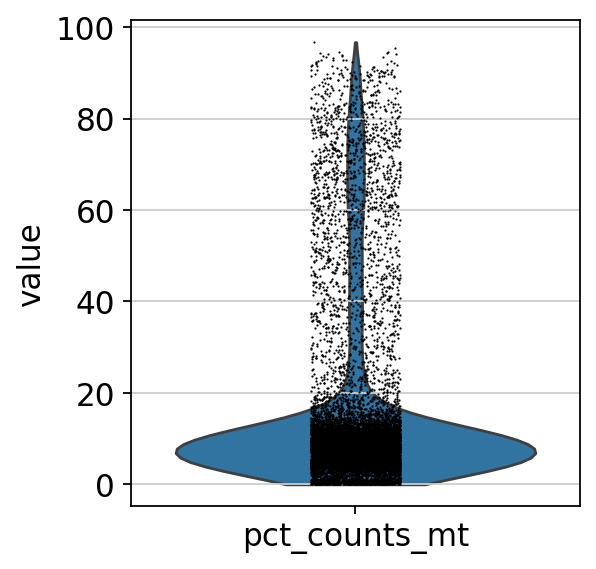

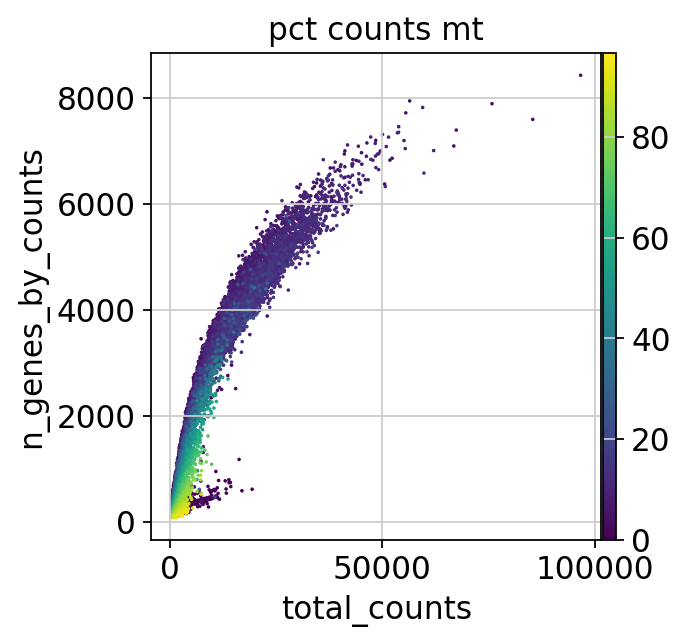

In [18]:
# Plot QC metrics
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [19]:
# Define a function to identify low-quality barcodes based on outlier detection via median absolute deviation (MAD)
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [20]:
# Flag outliers which hace QC metric values outside of a range of 5 MAD 
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    8831
True     2532
Name: outlier, dtype: int64

In [21]:
# Additionally remove cells with high expression of mitochondrial genes (percentage of mitochondrial counts outside of a range of 3 MAD)
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) 
adata.obs.mt_outlier.value_counts()

False    9409
True     1954
Name: mt_outlier, dtype: int64

In [22]:
# Actually filter cells
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 11363
Number of cells after filtering of low quality cells: 8521


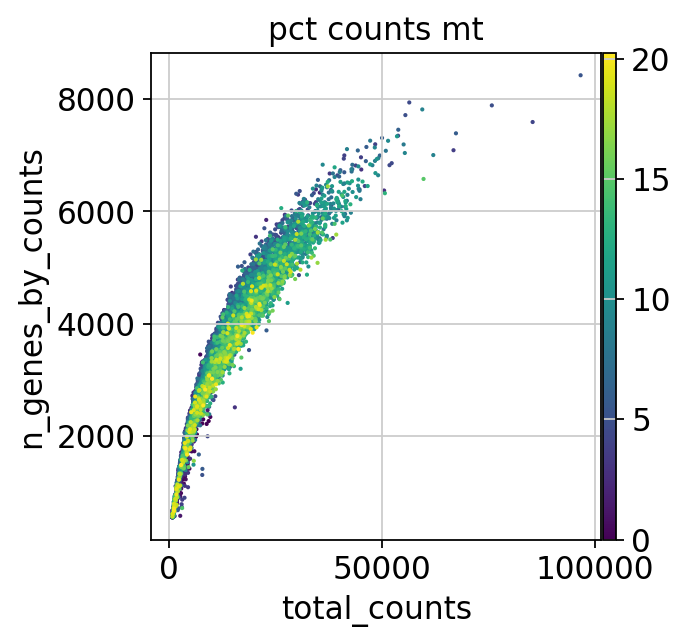

In [24]:
# Plot total counts versus number of genes by counts
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Ambient RNA correction

In [27]:
# Copy anndata object. Normalize it, reduce its dimensionality and compute default Leiden clusters on the processed copy. This is to provide clustering, which can 
# enhance ambient RNA correction
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [30]:
# save the cell names, gene names and the data matrix of the filtered cellranger output
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [31]:
# Load the raw gene by cells matrix and transpose
adata_raw = sc.read_10x_h5(
    filename="/mnt/sdb/qdang/singlecell/epi/E135/outs/raw_feature_bc_matrix.h5",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

In [33]:
# construct a sSoupChannel from the table of droplets and the table of cells. 
#Next, we add metadata to the SoupChannel object which can be any metadata in the form of a data frame
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

1270 genes passed tf-idf cut-off and 73 soup quantile filter.  Taking the top 73.
Using 659 independent estimates of rho.
Estimated global rho of 0.01
Expanding counts from 24 clusters to 8521 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [34]:
# Store soupX-corrected counts as an additional layer
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [35]:
# Filter out genes that are not detected in at least 20 cells
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 31054
Number of genes after cell filter: 15728


# Detect doublets

In [37]:
data_mat = adata.X.T

In [38]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~6817 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1067 cells excluded from training.
iter=1, 1026 cells excluded from training.
iter=2, 1020 cells excluded from training.
Threshold found:0.43
633 (7.4%) doublets called


In [39]:
# Add scDblfiner doublet classification and score to our anndata object
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    7888
doublet     633
Name: scDblFinder_class, dtype: int64

# Perform normalisation

In [43]:
# Normalize each cell by total counts over all genes, then apply log1p transform
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [47]:
# Preliminary clustering for differentiated normalisation. This is important for scran normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [48]:
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [50]:
# Compute size factors
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [51]:
# Save size_factors in .obs and are now able to normalize the data and subsequently apply a log1p transformation. 
# Scran normalisation is suited for selecting highly variable features
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

## Select meaningful features 

In [5]:
# Save our anndata object
ro.globalenv["adata"] = adata

In [6]:
# Call feature selection with deviance on the non-normalized counts matrix. 
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [7]:
# Export the binomial deviance values as a vector.
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [8]:
# sort the vector and select the top 4,000 highly deviant genes
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [12]:
# Set the .X layer to log-normalised counts for PCA and dimensionality reduction
adata.X = adata.layers["log1p_norm"]

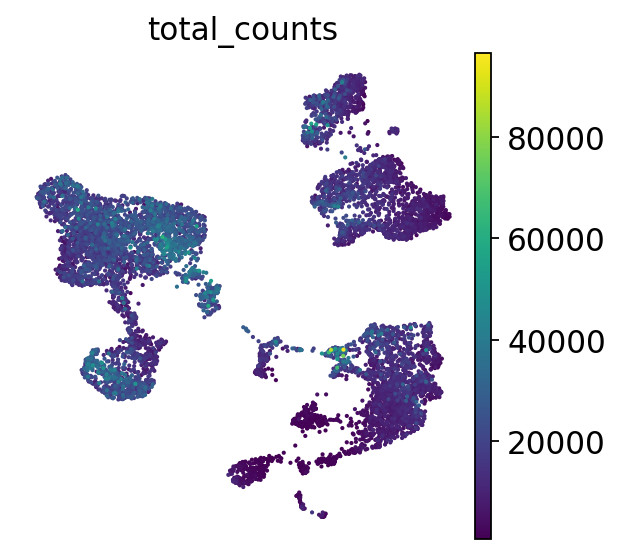

In [18]:
# setting highly variable as highly deviant, run PCA and UMAP 
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts")

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


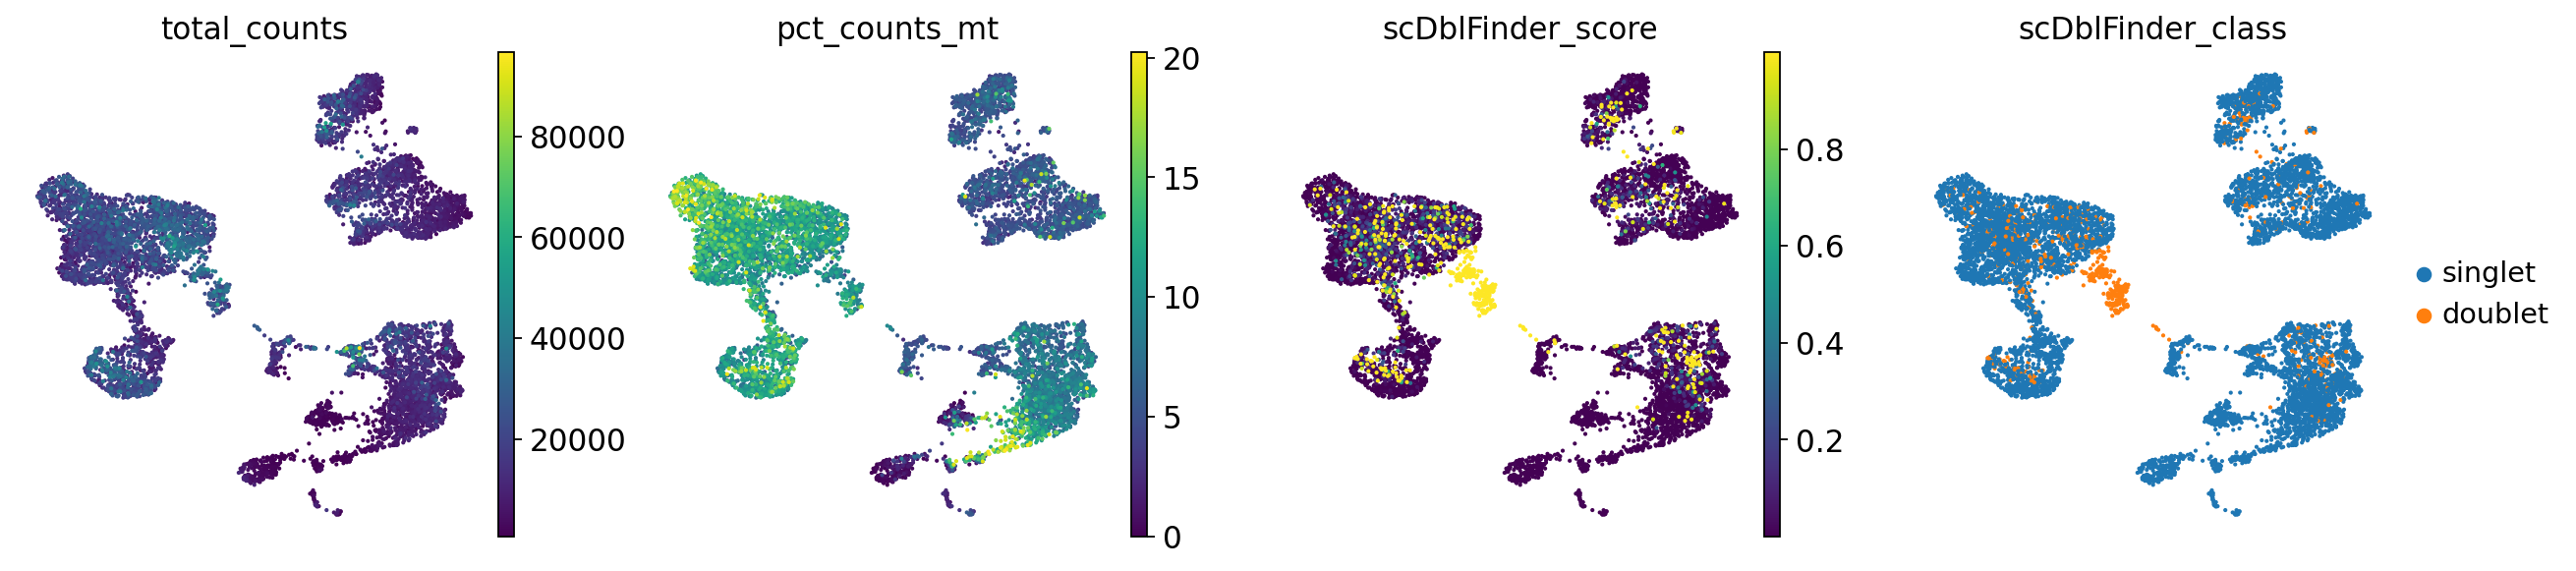

In [19]:
####Inspecting QC metrics to identify low-quality barcodes or doublets####
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


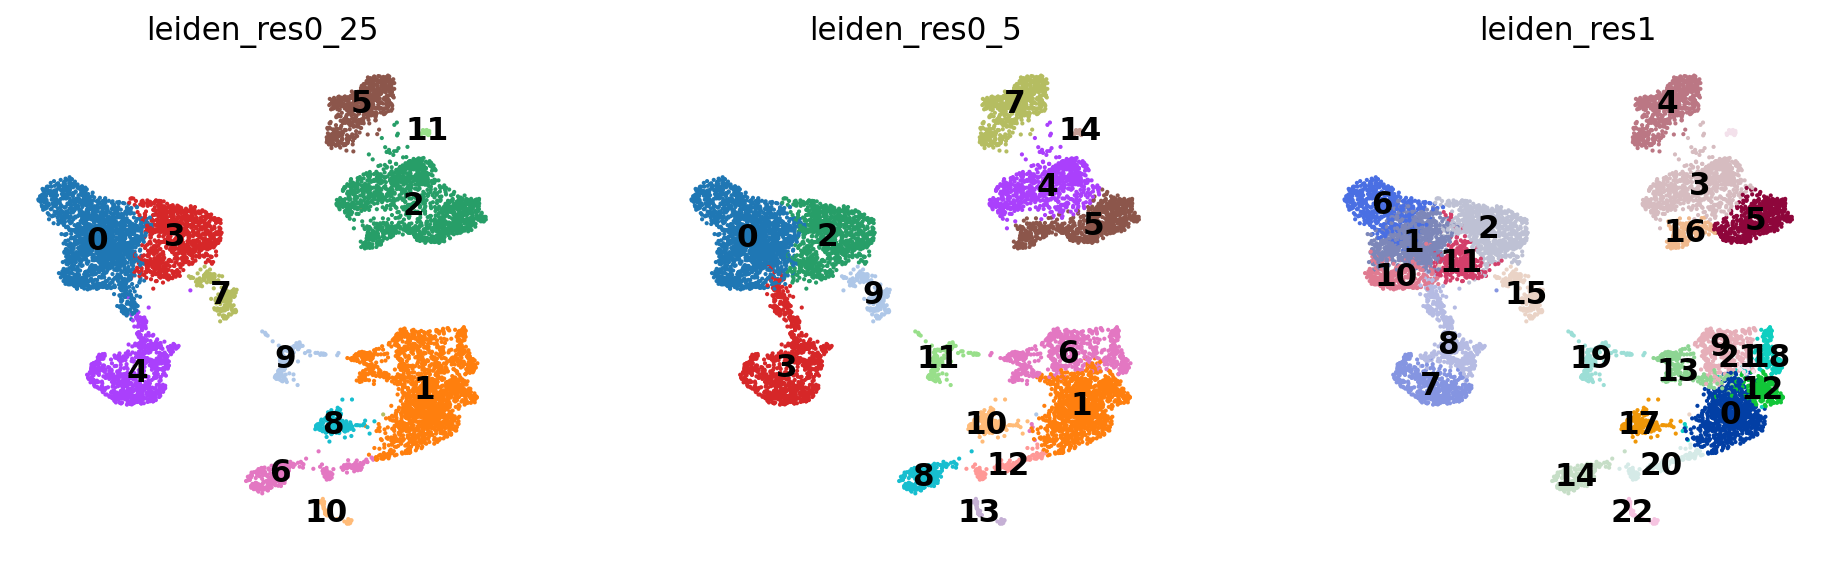

In [23]:
# Perform leiden clustering
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [2]:
adata

AnnData object with n_obs × n_vars = 8521 × 15728
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    laye

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


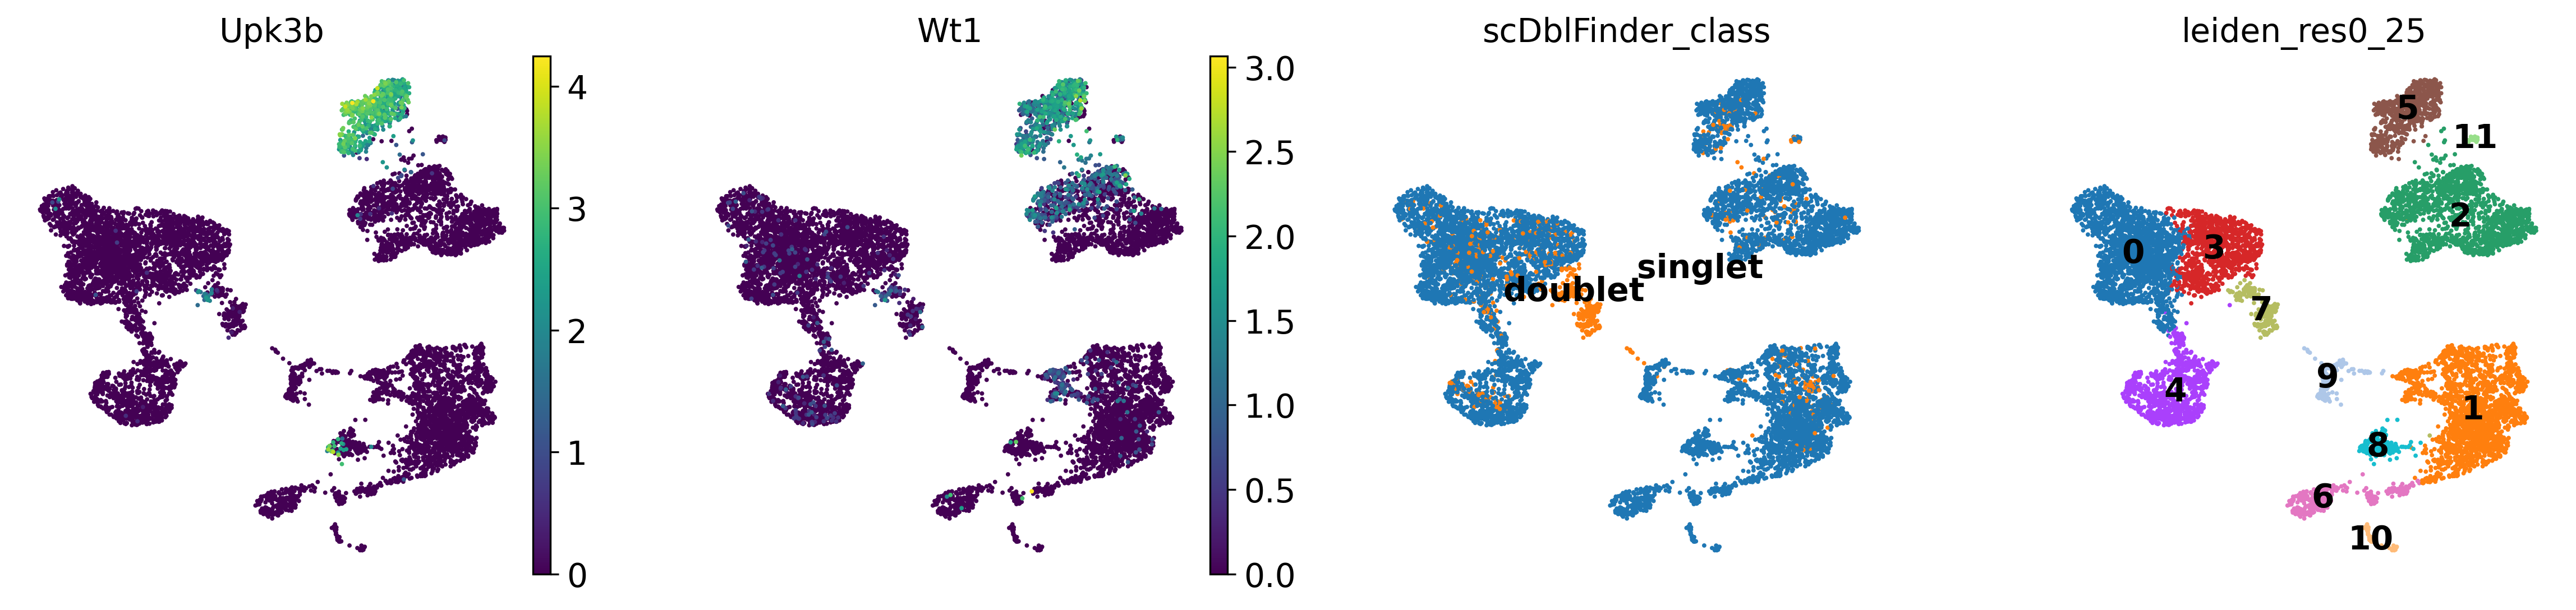

In [114]:
sc.pl.umap(adata, color=['Upk3b','Wt1','scDblFinder_class','leiden_res0_25'],legend_loc='on data')

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


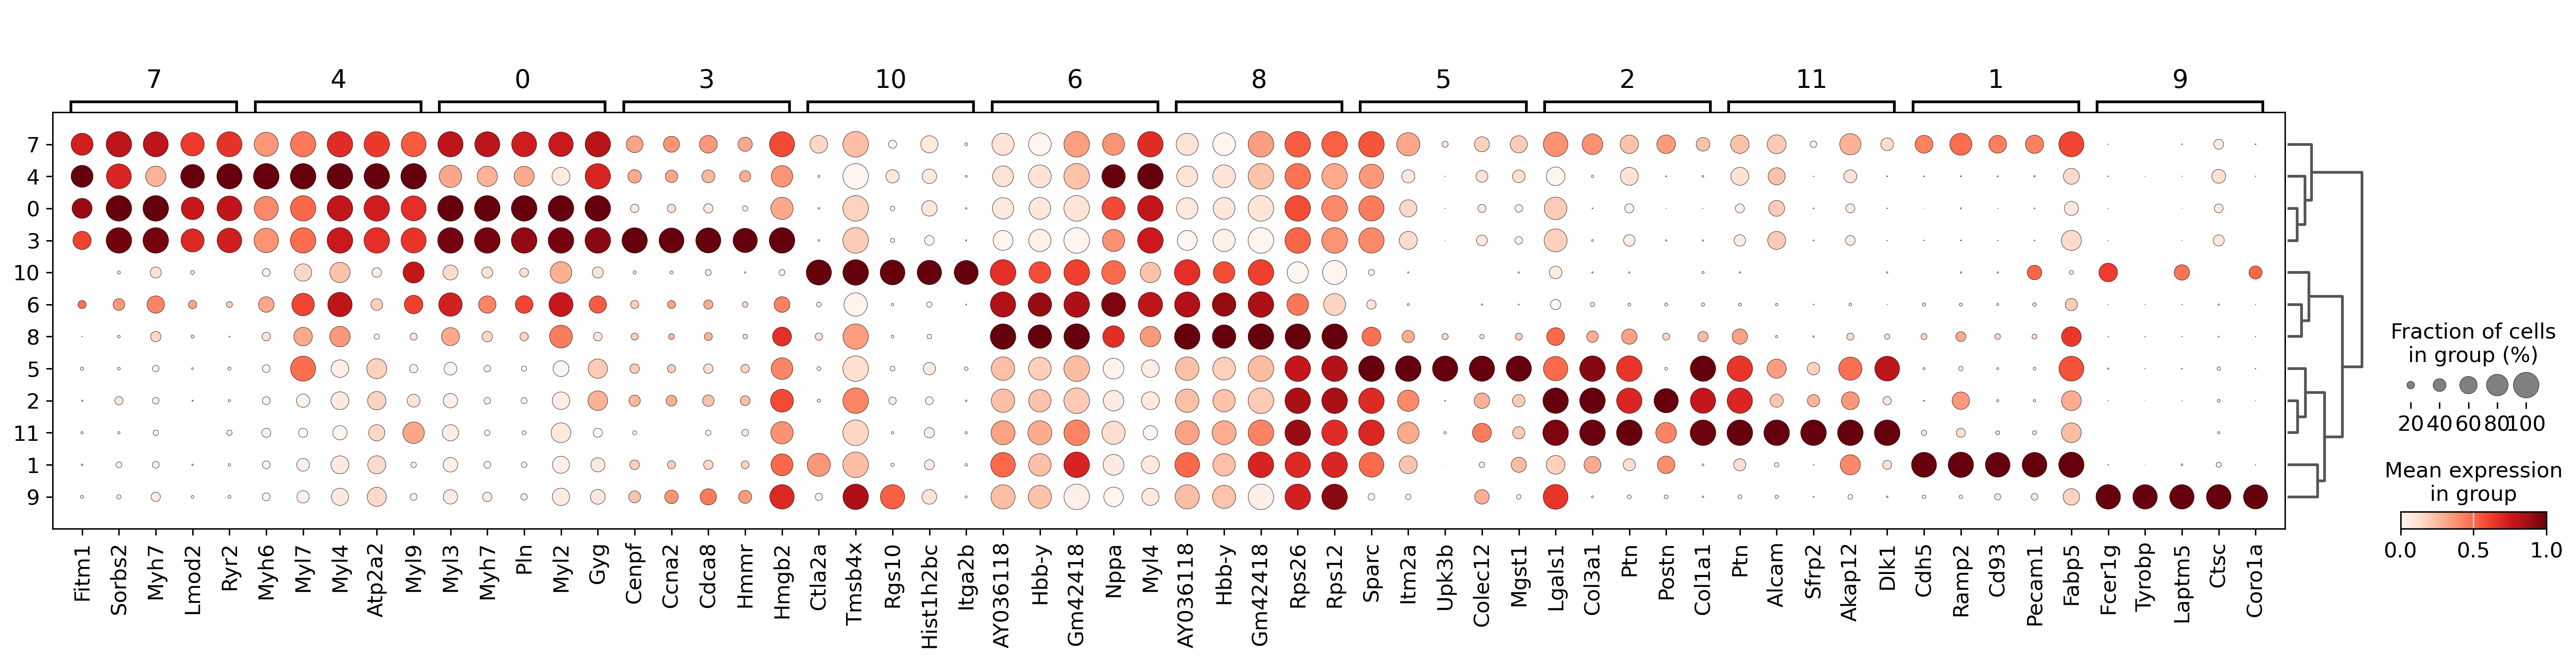

In [115]:
# Calculate the differentially expressed genes for every cluster
sc.tl.dendrogram(adata, groupby="leiden_res0_25")
sc.tl.rank_genes_groups(
    adata, groupby="leiden_res0_25", method="wilcoxon", key_added="dea_leiden_0_25", use_raw=False
)
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_25", standard_scale="var", n_genes=5, key="dea_leiden_0_25"
)

In [6]:
# Remove doublets and low-quality cells
adata2 = adata[-adata.obs['leiden_res0_25'].isin(['6','7','8'])]
adata2

View of AnnData object with n_obs × n_vars = 7867 × 15728
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [7]:
# renormalise after subsetting
adata2.X = adata2.layers['soupX_counts'].copy()
scales_counts = sc.pp.normalize_total(adata2, target_sum=None, inplace=False)
# log1p transform
adata2.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [11]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata2.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

2024-10-08 11:19:52.364618: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 11:19:52.390806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 11:19:52.390827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 11:19:52.391607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 11:19:52.396351: I tensorflow/core/platform/cpu_feature_guar

In [12]:
#Preliminary clustering for differentiated normalisation for scran normalisation again
adata_pp = adata2.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [14]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [15]:
adata2.obs["size_factors"] = size_factors
scran = adata2.X / adata2.obs["size_factors"].values[:, None]
adata2.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [17]:
ro.globalenv["adata"] = adata2

In [18]:
# Select variable features again
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [20]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata2.var_names.shape, dtype=bool)
mask[idx] = True

adata2.var["highly_deviant"] = mask
adata2.var["binomial_deviance"] = binomial_deviance

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


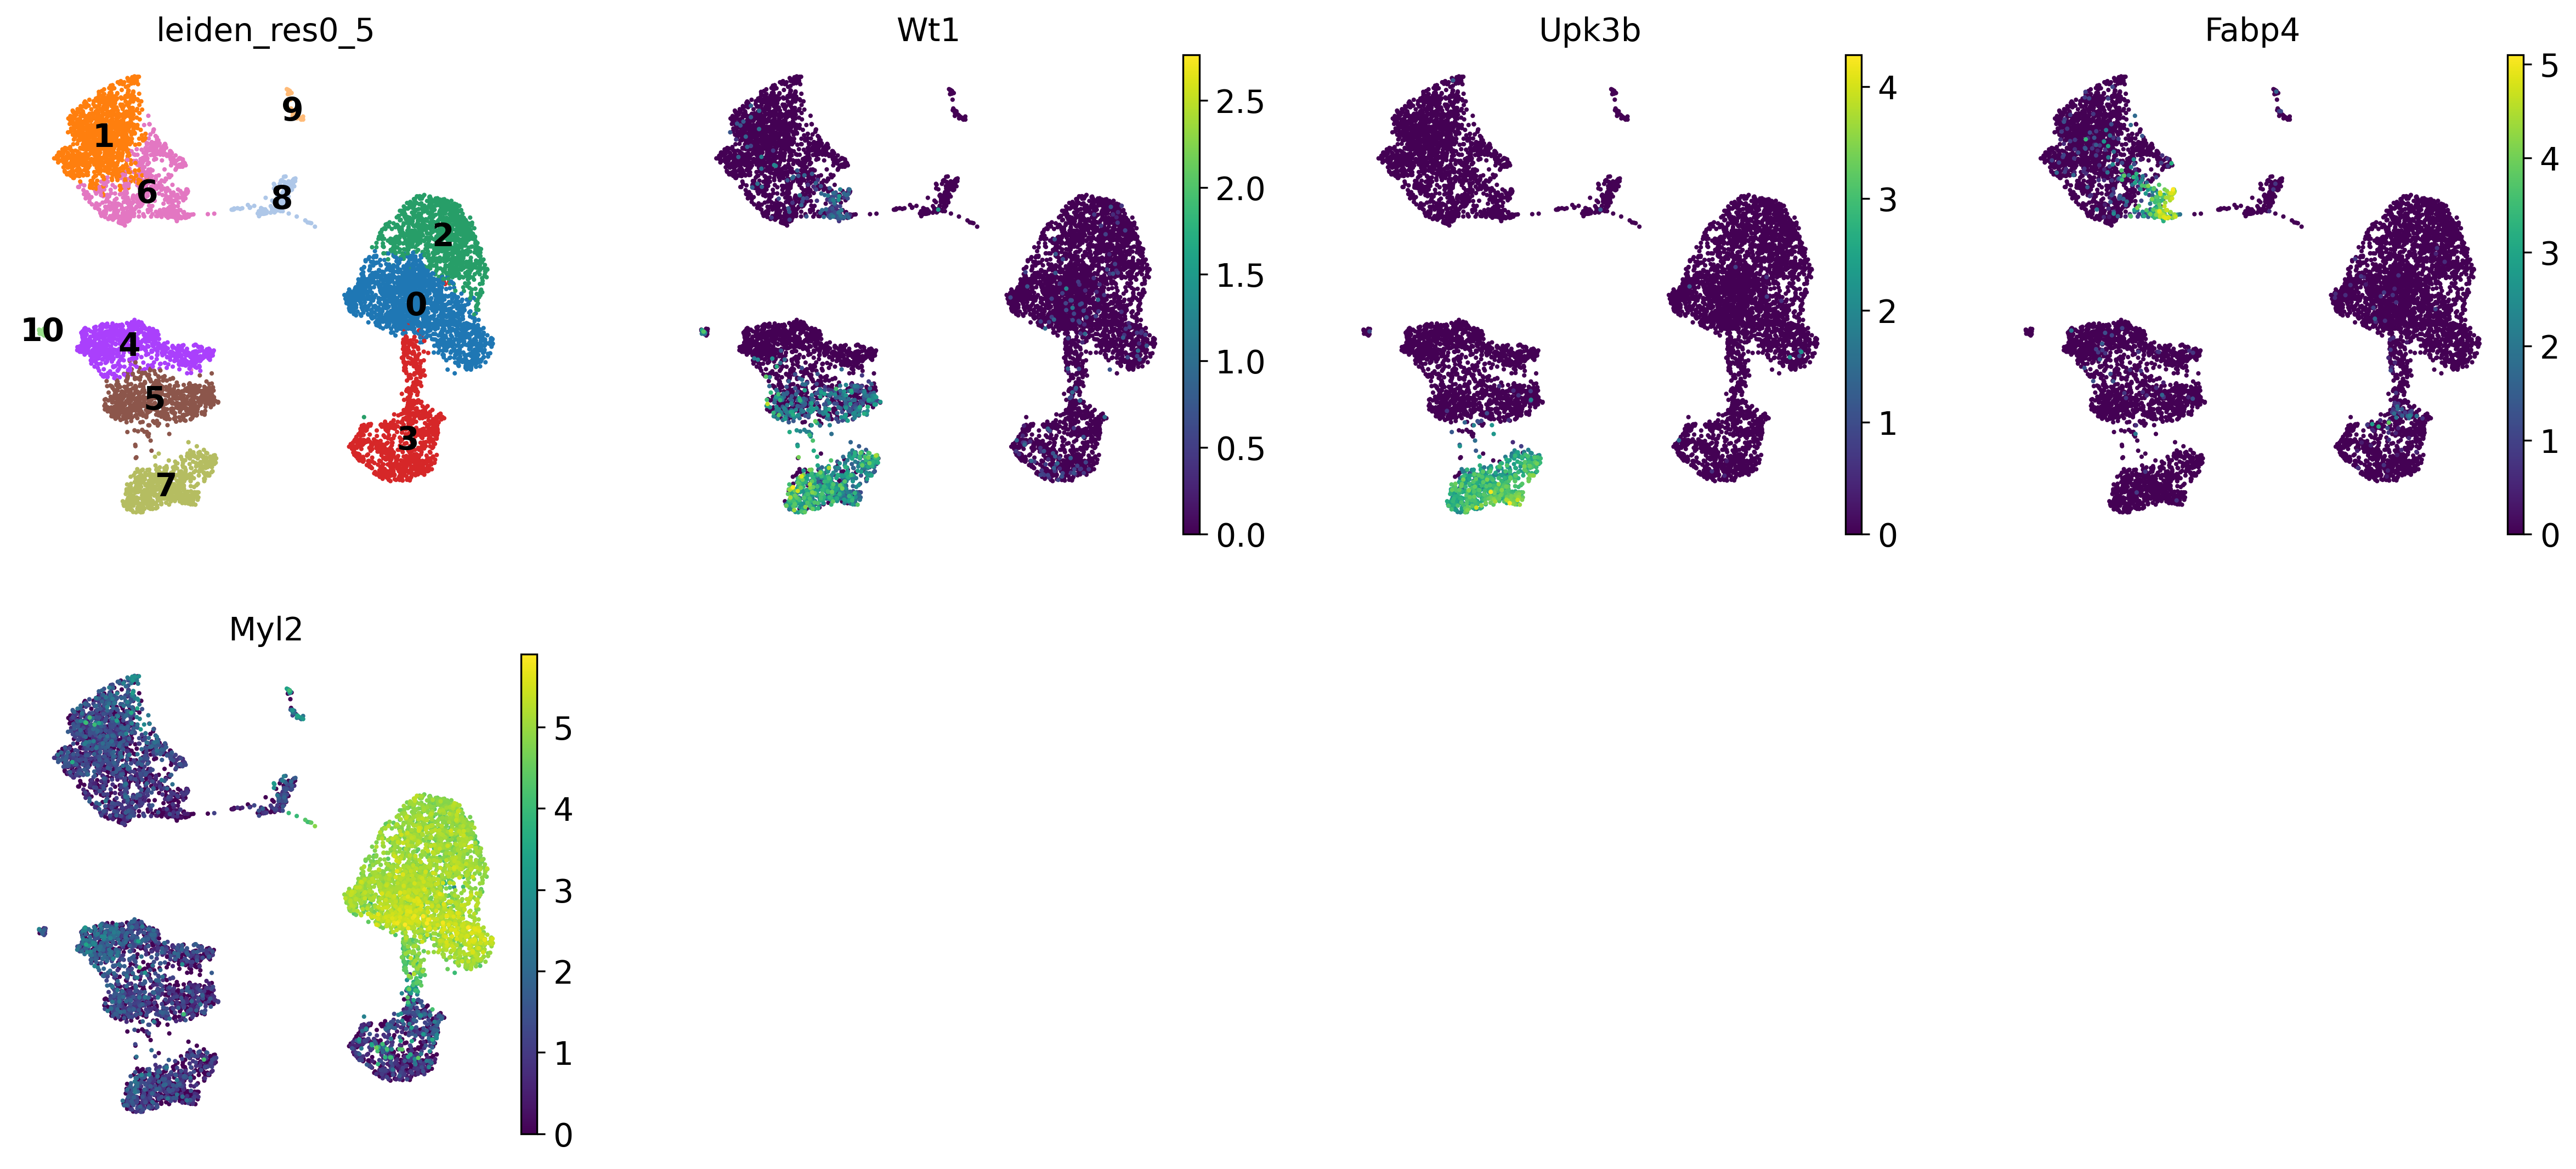

In [141]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata2.X = adata2.layers["log1p_norm"]
adata2.var["highly_variable"] = adata2.var["highly_deviant"]
sc.pp.pca(adata2, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata2, key_added="leiden_res1", resolution=1.0)
sc.pl.umap(
    adata2,
    color=["leiden_res0_5", "Wt1",'Upk3b','Fabp4','Myl2'],
    legend_loc="on data",
)

In [28]:
adata2

AnnData object with n_obs × n_vars = 7867 × 15728
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    laye

In [2]:
# Epicardial cells are cells that highly express epicardial markers such as Upk3b and Wt1 (cluster 7)
epi = adata[adata.obs['leiden_res0_5'].isin(['7'])]
epi

View of AnnData object with n_obs × n_vars = 649 × 15728
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_ce

In [ ]:
epi.write('/mnt/sdb/qdang/meso_project/heart_meso.h5ad')

# Train CellTypist annotation based on a published dataset: https://www.nature.com/articles/s41467-022-35691-7

In [16]:
# Load the reference dataset
adata_ref = sc.read("/mnt/sdb/qdang/singlecell/PRJNA795900/PRJNA795900.h5ad")
print(adata_ref)

AnnData object with n_obs × n_vars = 25436 × 30976
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Barcode', 'sample', 'cell', 'strain', 'barcode_id', 'sequence', 'name', 'id', 'read', 'batch', 'stage', 'zone', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'subsets_Ribo_sum', 'subsets_Ribo_detected', 'subsets_Ribo_percent', 'total', 'raw_cxds_score', 'raw_bcds_score', 'raw_hybrid_score', 'demult_dblt_call', 'low.nexprs', 'low.ndet', 'high.ndet', 'high.mito', 'low_lib_size_all_adapt', 'low_n_features_all_adapt', 'high_subsets_Mito_percent_all_adapt', 'discard_all_adapt', 'low_lib_size_all_adaptWRibo', 'low_n_features_all_adaptWRibo', 'high_subsets_Mito_percent_all_adaptWRibo', 'high_subsets_Ribo_percent_all_adaptWRibo', 'discard_all_adaptWRibo', 'multi.outlierNoRibo', 'multi.outlierWithRibo', 'PassQC_manual7', 'filter', 'filt_cxds_score', 'filt_bcds_score', 'filt_hybrid_score', 'scdsManual_possible_doublet', 'PassQC_manual7ScdsManual', 'RN

In [17]:
#Below is the pre-processing for the reference dataset (which we will use to train the CellTypist model). 
# Counts are normalized to 10,000 counts per cell, then log1p-transformed
adata_refcelltypist2 = adata_ref.copy()  # make a copy of our adata
adata_refcelltypist2.X = adata_ref.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_refcelltypist2, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_refcelltypist2)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_refcelltypist2.X = adata_refcelltypist2.X.toarray()

In [29]:
#We pro-process the query dataset in the same manner
adata_celltypist = adata2.copy()  # make a copy of our adata
adata_celltypist.X = adata2.layers["soupX_counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [26]:
# The `cell_type_spec` in `adata_ref.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_refcelltypist, labels = 'cell_type_spec', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 7989 non-expressed genes are filtered out
🔬 Input data has 25436 cells and 22987 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 1974 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [30]:
new_model.write('/mnt/sdb/qdang/singlecell/epi/model_from_PRJNA795900.pkl')
new_model

CellTypist model with 8 cell types and 1974 features
    date: 2024-01-02 10:23:08.595600
    cell types: atrial_cm, blood, ..., ventricular_cm
    features: Sox17, Arfgef1, ..., mt-Cytb

In [30]:
# Annotate the query dataset (E13.5 mouse heart scRNA-seq) using the reference
predictions2 = celltypist.annotate(adata_celltypist, model = '/mnt/sdb/qdang/singlecell/epi/model_from_PRJNA795900.pkl', majority_voting = True)

🔬 Input data has 7867 cells and 15728 genes
🔗 Matching reference genes in the model
🧬 1900 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [31]:
# Convert annotation prediction into an anndata object
predictions_adata2 = predictions2.to_adata()

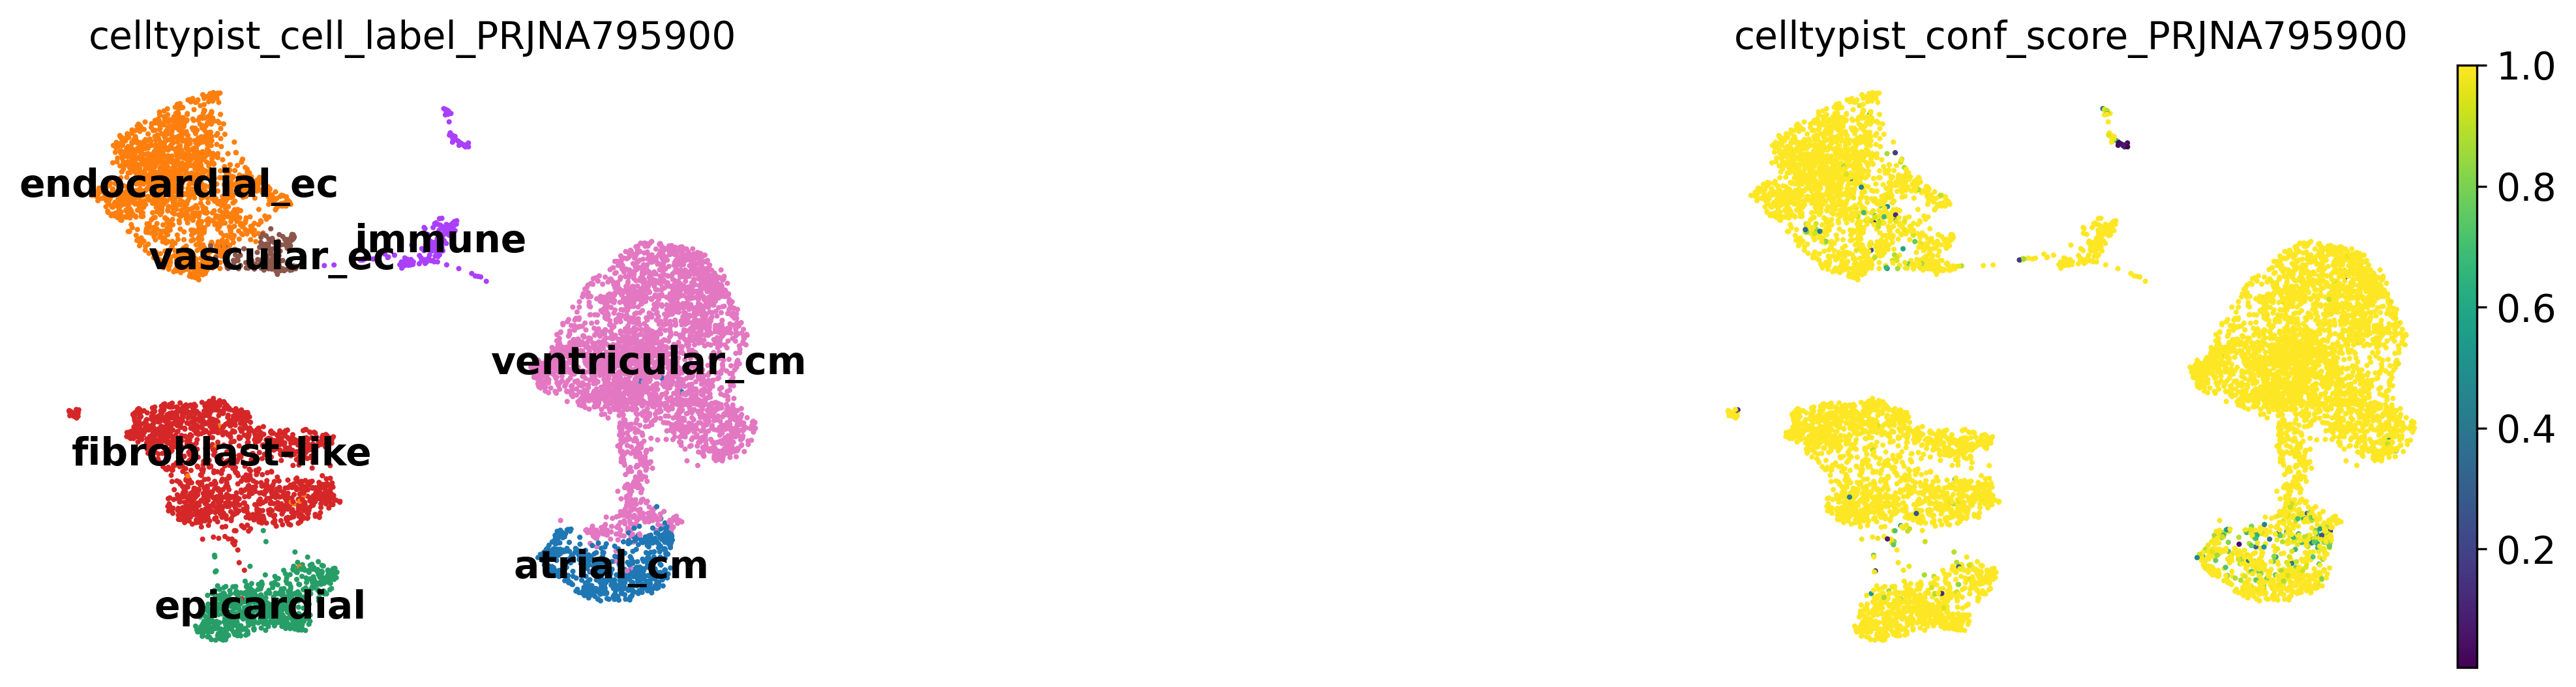

In [34]:
# Transfer annotation label and score
adata2.obs["celltypist_cell_label_PRJNA795900"] = predictions_adata2.obs.loc[
    adata2.obs.index, "majority_voting"
]
adata2.obs["celltypist_conf_score_PRJNA795900"] = predictions_adata2.obs.loc[
    adata2.obs.index, "conf_score"
]
sc.pl.umap(
    adata2,
    color=["celltypist_cell_label_PRJNA795900", "celltypist_conf_score_PRJNA795900"],
    frameon=False,
    sort_order=False,
    wspace=1, legend_loc = 'on data'
)

In [35]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "endocardial_ec": "Endocardial EC",
    "vascular_ec": "Cardiac vascular EC",
    "immune": "Immune",
    "ventricular_cm": "Ventricular CM",
    "atrial_cm": "Atrial CM",
    "epicardial":'Mesothelium',
    "fibroblast-like": "Mesenchymal derivatives"
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata2.obs["cell_type"] = adata2.obs["celltypist_cell_label_PRJNA795900"].map(cluster2annotation).astype("category")

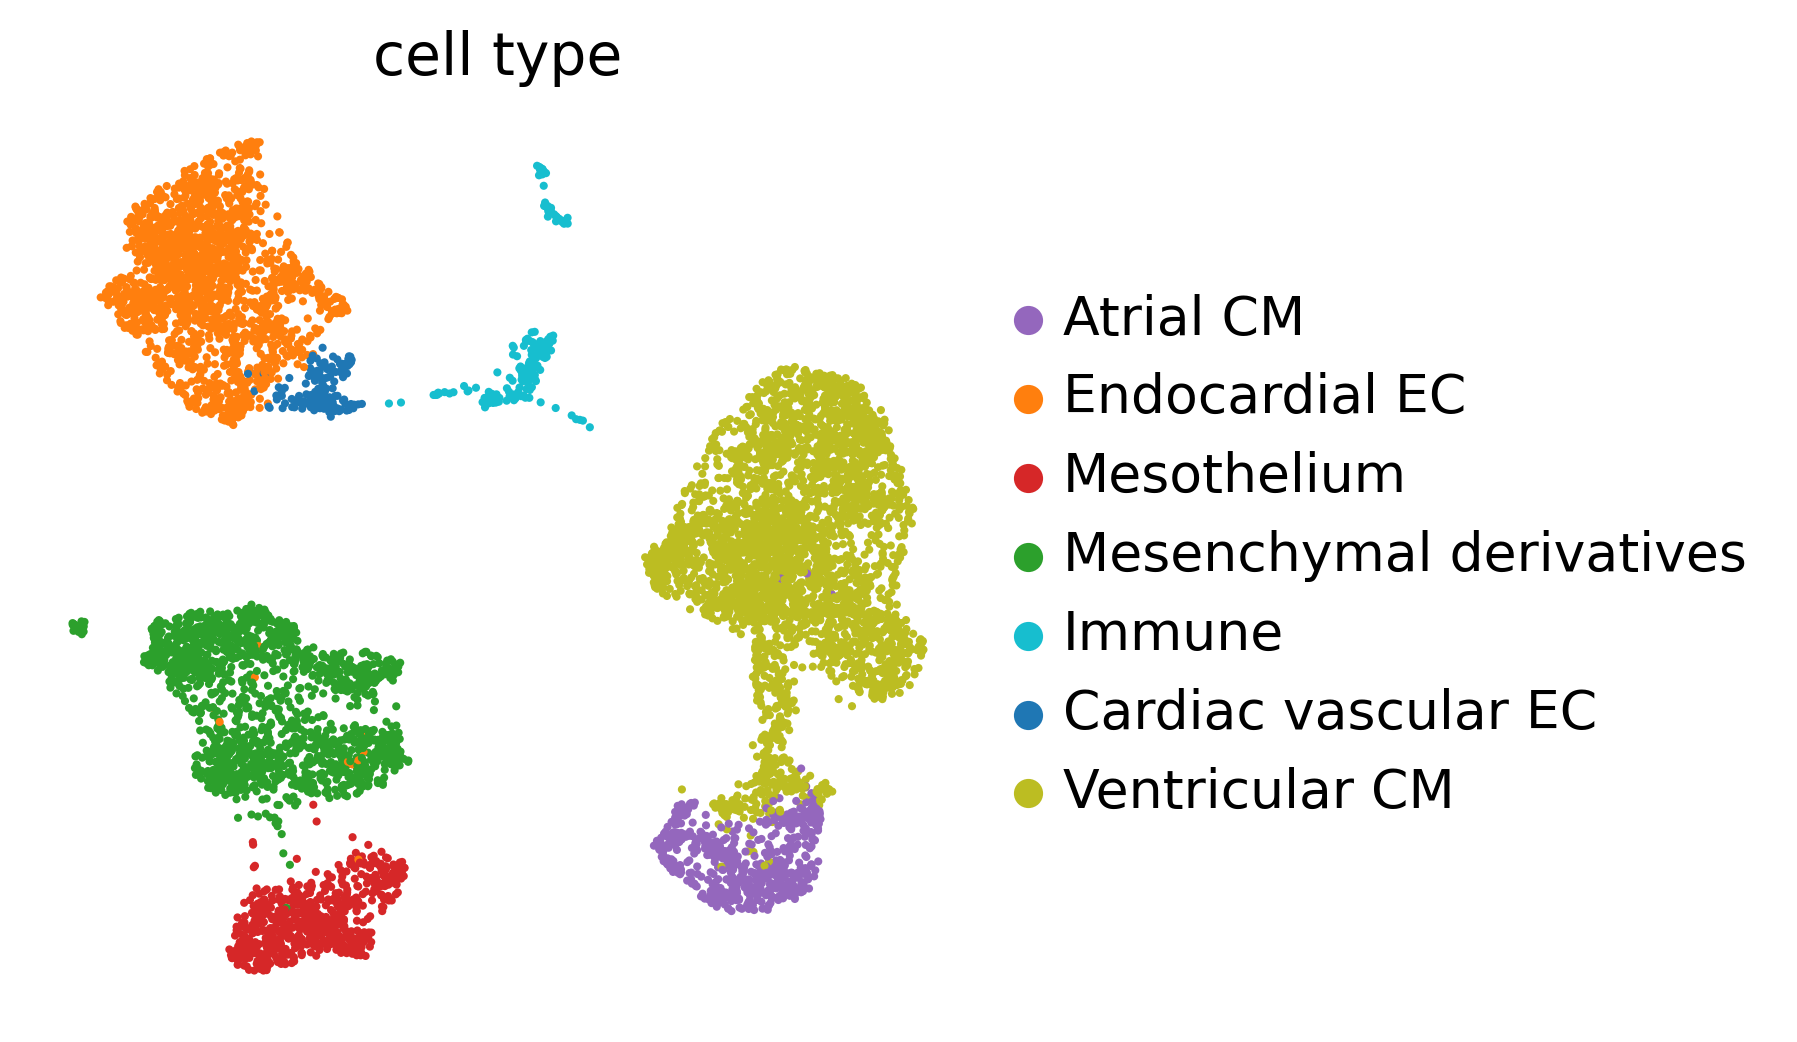

In [48]:
sc.pl.umap(
    adata2,
    color=["cell type"],
    frameon=False,
    sort_order=False,
    wspace=1,
    palette={"Mesenchymal derivatives": "tab:green", "Mesothelium": "tab:red", "Endocardial EC":"tab:orange",
            "Immune":"tab:cyan", "Cardiac vascular EC":"tab:blue","Ventricular CM":"tab:olive","Atrial CM":"tab:purple"},
    save='heart_umap.png'
)

In [63]:
marker_genes_dict = {
    "Atrial CM": ["Sln"],
    "Ventricular CM": ["Myl2"],
    "Mesothelium": ["Upk3b","Wt1"],
    "Endocardial EC": ['Npr3'],
    "Cardiac vascular EC": ["Fabp4"],
    "Mesenchymal derivatives":["Postn",'Snai2','Tcf21'],
    "Immune":["C1qa"]
}

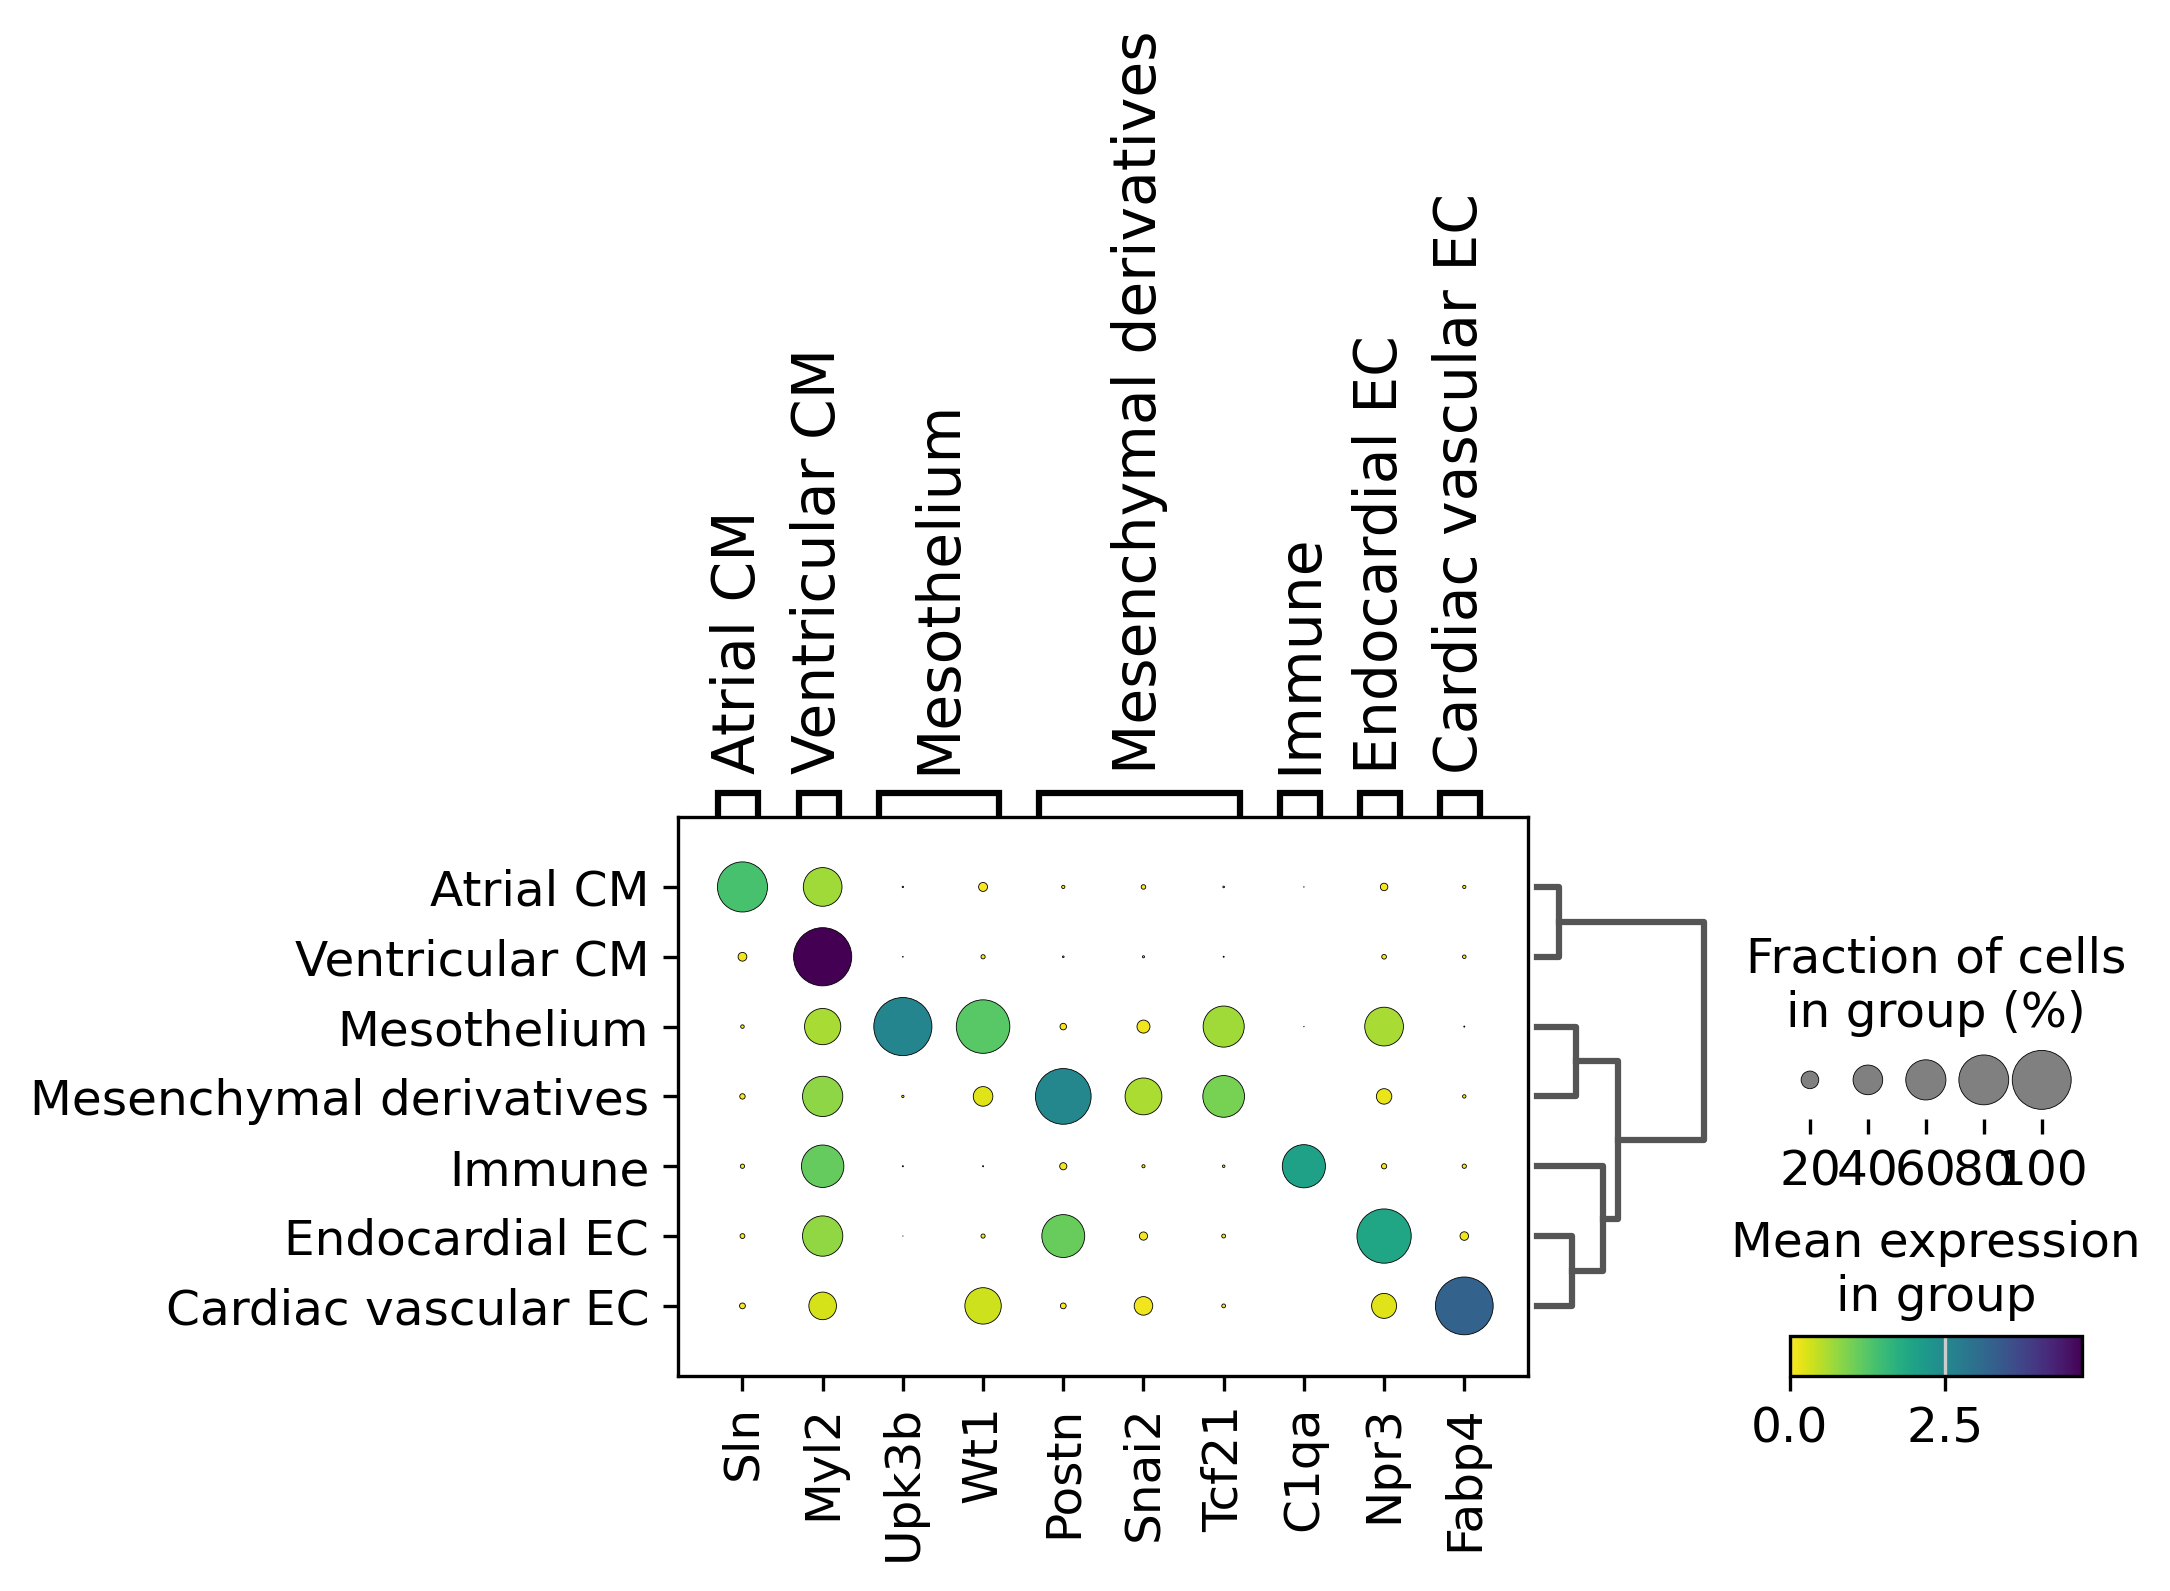

In [64]:
# Plot marker genes
sc.pl.dotplot(adata2, marker_genes_dict, groupby="cell_type", layer='log1p_norm', dendrogram=True,
              cmap="viridis_r", save='matrix.pdf')